In [1]:

!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib
!pip install yfinance
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
     ---------------------------------------- 0.0/315.9 kB ? eta -:--:--
     --- ----------------------------------- 30.7/315.9 kB 1.3 MB/s eta 0:00:01
     -------- ---------------------------- 71.7/315.9 kB 975.2 kB/s eta 0:00:01
     -------------- ----------------------- 122.9/315.9 kB 1.0 MB/s eta 0:00:01
     ----------------- ------------------ 153.6/315.9 kB 919.0 kB/s eta 0:00:01
     ------------------------ ------------- 204.8/315.9 kB 1.0 MB/s eta 0:00:01

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable


# Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.utils.data import *

from sklearn.preprocessing import MinMaxScaler

import pandas as pd

import matplotlib.pyplot as plt


import yfinance as yf


# Data Processing

In [3]:
# time step to predict ahead, creates input sequences
def create_lstm_data(data, time_step=1, future = 0):
    """Splits given stock data into a X, y dataset

    Args:
        data (_type_): _description_
        time_step (int, optional): Amount of timesteps of input for model to train on. Defaults to 1.
        future (int, optional): Amount of timesteps that will be predicted. Defaults to 0.

    Returns:
        _type_: _description_
    """
    x_vec, y_vec = [], []
    # formats data so y = t and x = t-1, ... , t-time_steps
    for i in range(len(data) - time_step):
        split = i + time_step
        # checks if data is of same length for concatentation
        length = data[split : split + future, 0].shape[0]
        if(length == future):
            x_vec.append(data[i : split, 0].unsqueeze(0))
            y_vec.append(data[split : split + future, 0].unsqueeze(0))
    # concats x into matrix and y into vector, needs unsqueeze to add single dimension for LSTM dimensions
    return torch.cat(x_vec,0).unsqueeze(-1), torch.cat(y_vec,0).unsqueeze(-1)

# create a dataset out of timeseries data, must be formatted first, tensor
# correct timeseries formatation
class TimeSeriesDataset(Dataset):
    """Creates a dataset out of a given X and Y

    Args:
        Dataset : Inherits parameters of Pytorch dataset class
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]
    

In [4]:
# Given multiple sets of pairs outputs a concatenated train and test dataset containing data from all pairs
def create_dataset(pairs, input_size, output_size, train_valid_ratio = 0.8):
    """Given set of pairs this creates a train and test dataset to train and test the model on

    Args:
        pairs (string, string): Pair of stocks
        input_size (int): Window of days to train on
        output_size (int): Window of days to predict
        train_test_ratio (float): Percent of data to be assign to train and test

    Returns:
        Dataset: Dataset of all pairs to train on
    """
    
    train_dataset_list = []
    valid_dataset_list = []
    
    scaler = MinMaxScaler(feature_range=(0,1))
    
    for (x, y) in pairs:
        # Get the spread for a pair
        x_data = yf.download(x, period='10y')['Close']
        y_data = yf.download(y, period='10y')['Close']
        spread = x_data - y_data
        spread = spread.values.reshape(-1,1)
  
        # Normalize the data
        normalized_data = torch.tensor(scaler.fit_transform(spread))
        train_valid_split = (int)(len(normalized_data) * train_valid_ratio)
        
        # Split data into train and test
        train_data = normalized_data[:train_valid_split]
        test_data = normalized_data[train_valid_split:]
        # Create train dataset
        X_train, y_train = create_lstm_data(train_data, input_size, output_size)
        train_dataset_i = TimeSeriesDataset(X_train,y_train)
        train_dataset_list.append(train_dataset_i)
        # Create test dataset
        X_test, y_test = create_lstm_data(test_data, input_size, output_size)
        valid_dataset_i = TimeSeriesDataset(X_test,y_test)
        valid_dataset_list.append(valid_dataset_i)
        
    train_dataset = torch.utils.data.ConcatDataset(train_dataset_list)
    valid_dataset = torch.utils.data.ConcatDataset(valid_dataset_list)
    
    return train_dataset, valid_dataset, scaler

# Model Architecture

The architecture used is the LSTM-Encoder-Decoder Model, in this implementation we are given x number of timestep to encode, and y number of timesteps to decoder. 

In [5]:
# Encoder block of the model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout = 0.5):
        super(Encoder,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout,
                           batch_first=True)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.rnn(x)
        
        return hidden, cell

# Decoder block of the model
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout = 0.5):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout,
                           )
        self.fc_out = nn.Linear(hidden_dim, 1)

    #predicts a single time step, with either y pred as input or y
    def forward(self, y, prev_hidden, prev_cell):

        y = y.unsqueeze(0)

        output, (hidden, cell) = self.rnn(y, (prev_hidden, prev_cell))

        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell
    
class EncoderDecoderWrapper(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.5, output_size = 1, teacher_forcing=0.3, device = 'cpu'):
        super(EncoderDecoderWrapper,self).__init__()
        self.encoder = Encoder(input_dim,num_layers,hidden_dim,dropout)
        self.decoder = Decoder(input_dim,num_layers,hidden_dim,dropout)
        self.teacher_forcing = teacher_forcing
        self.device = device
        self.output_size = output_size

    def forward(self, source, target=None):
        
        # Number of elements in each batch
        batch_size = source.shape[0]
        
        # Output should be same size as target during training
        if(target != None):
            target_len = target.shape[1]
            assert(target_len == self.output_size)
        
        prev_hidden, prev_cell = self.encoder(source)

        prev_target = source[:,-1]
            
        outputs = torch.zeros(batch_size,self.output_size).to(self.device)
        
        for t in range(self.output_size):
            
            prediction, prev_hidden, prev_cell = self.decoder(prev_target, prev_hidden, prev_cell)

            outputs[:,t] = prediction.squeeze(1)
            
            # Chance of using actual next value vs chance of using predicted in training to predict next value 
            prev_target = target[:,t] if torch.rand(1) < self.teacher_forcing and target != None else prediction
        
        return outputs

# Training Loop

In [65]:
# Optimizes parameters of model and prints out loss
def train_epoch(model,dataloader,loss_fn,optimizer,device = 'cpu'):
    
    model.train()
    running_loss = 0.0

    # Loop to iterate through all elements in the dataset
    for X, y in dataloader:
        X_train, y_train = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        output = model(X_train, y_train)
        loss = loss_fn(output, y_train.squeeze(2))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(dataloader)
    print(f'Train Loss: {running_loss}')
    
    return running_loss

# Validation Loop

In [7]:
# Outputs validation loss
def valid_loss(model,dataloader,loss_fn,device = 'cpu'):
    
    model.eval()
    running_loss = 0.0
    for X, y in dataloader:
        X_test, y_test = X.to(device).to(torch.float32).clone(), y.to(device).to(torch.float32).clone()
        
        output = model(X_test)
        loss = loss_fn(output, y_test.squeeze(2)).item()
        running_loss += loss
    running_loss /= len(dataloader)
    print(f'Validation Loss: {running_loss}')
    
    return running_loss

# Formatting Data

In [60]:
# Parameters for data
BATCH_SIZE = 128
input_size = 30
output_size = 60

In [61]:
# Pairs to train model on
pairs = [('CSGP','PLD'),("TJX","DLTR"),("AEP",'XEL'),
         ("AMD","NXPI"),("AMD","ADI"),("QCOM","TSM"),("QCOM","NXPI"),
         ("ABBV",'AMGN'),("CRM","WDAY"),("COF","DFS"),("YUM","DRI")]

# Creating dataset
train_dataset, valid_dataset, scalar = create_dataset(pairs, input_size, output_size)

# Loading dataset into a dataloader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

# Training

In [68]:
# Hyper parameters (need layers to be higher than 1 for dropout to work)
input_dim = 1
num_layers = 2
hidden_size = 15
dropout = 0.5
teacher_forcing = 0.2

device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EncoderDecoderWrapper(input_dim,num_layers,hidden_size,dropout,output_size,teacher_forcing,device).to(device)

In [69]:
lr = 0.001
num_epochs = 1
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Epoch: 0
Train Loss: 0.04662908277620213


Text(0.5, 1.0, 'Train vs Validation Loss')

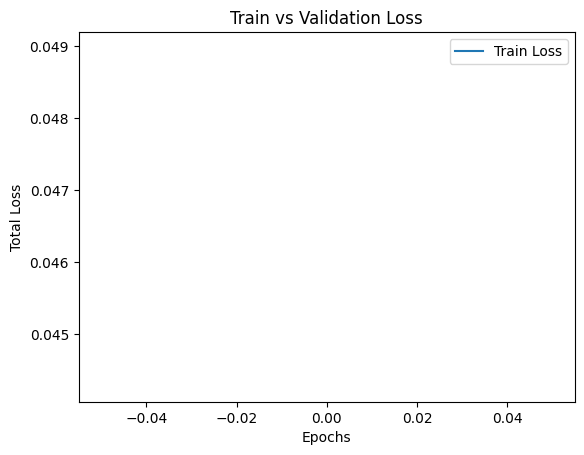

In [70]:

train_loss_i = []
valid_loss_i = []
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    loss_train = train_epoch(model, train_dataloader, loss, optimizer, device)
    #loss_valid = valid_loss(model, valid_dataloader, loss, device)
    train_loss_i.append(loss_train)
    #valid_loss_i.append(loss_valid)
    #lr_scheduler.step()
plt.plot(train_loss_i, label =  "Train Loss")
#plt.plot(valid_loss_i, label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Train vs Validation Loss")

# Testing

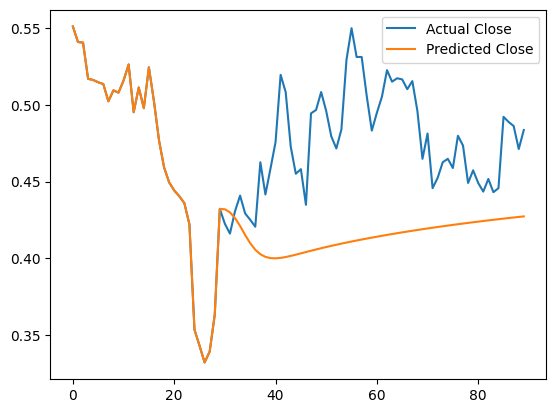

In [67]:
valid_dataset_i = valid_dataset.datasets[2]

X = valid_dataset_i.X
y = valid_dataset_i.y

with torch.inference_mode():
    predicted = model(X.to(device).to(torch.float32)).to(device)

i = 240

pred_with_x = torch.concat([X.squeeze(2),predicted.cpu()],1)
y_with_x = torch.concat([X.squeeze(2),y.squeeze(2)],1)

true_y = scalar.inverse_transform(pred_with_x)
true_y_pred = scalar.inverse_transform(y_with_x)

plt.plot(y_with_x[i], label = 'Actual Close')
plt.plot(pred_with_x[i], label = 'Predicted Close')
plt.legend()

#true_y_pred[1], true_y_train[1]

# Backtesting

In [ ]:
import yfinance as yf
import pandas as pd

# Download HMC and MYMTF price data:
hmc_data: pd.Series = yf.download('HMC', period='10y')['Close']
hymtf_data: pd.Series = yf.download('HYMTF', period='10y')['Close']
# Calculate the spread:
spread: pd.Series = hymtf_data - hmc_data

ROLLING_WINDOW = output_size     # This is used for determining how many days ahead to forcast
TRAINING_PERIOD =  input_size  # This is the number of days to use for each prediction
MONEY_PER_TRADE = 50000 # Capital to allocate to each trade in the pairs trade

# Convert capital to shares:
hmc_share_quant = MONEY_PER_TRADE/hmc_data
hymtf_share_quant = MONEY_PER_TRADE/hymtf_data

# How Forecasting is Being Used

Currently I am fitting a LSTM Encoder-Decoder Model to previous data. I then used the trained model to forcast values of the spread starting at the current date using a specified window.

I then use the pulled mean and standard deviation to calculate bollinger bands then check for arbitrage opportunities.

In [ ]:
import pandas as pd
import torch.functional as F

daily_returns = []
trade_log = []
position_open = False
position_type = None

for date, current_spread in spread.items():
    if date not in hmc_data.index or date < spread.index[TRAINING_PERIOD]:
        continue
    
    reg_index = spread.index.get_loc(date)
    
    # Forecast the spread for the next ROLLING_WINDOW days
    forecast_data = model(spread.iloc[reg_index - TRAINING_PERIOD: reg_index])
    # Calculate rolling mean
    rolling_mean = F.avg_pool1d(forecast_data.view(1, 1, -1), kernel_size=ROLLING_WINDOW, stride=1).view(-1)

    # Calculate rolling standard deviation
    squared_tensor = forecast_data ** 2
    rolling_squared_mean = F.avg_pool1d(squared_tensor.view(1, 1, -1), kernel_size=ROLLING_WINDOW, stride=1).view(-1)
    rolling_std = (rolling_squared_mean - rolling_mean ** 2).sqrt()
    # Calculate upper and lower 
    upper_band = rolling_mean + (rolling_std * 0.8)
    lower_band = rolling_mean - (rolling_std * 0.8)

    upper_band_value = upper_band
    lower_band_value = lower_band
    mean_value = rolling_mean
    hmc_price = hmc_data.get(date, None)
    hymtf_price = hymtf_data.get(date, None)
    hmc_shares = hmc_share_quant.get(date, None)
    hymtf_shares = hymtf_share_quant.get(date, None)
    if current_spread < lower_band_value and not position_open:
        # Open a pairs trade position (short HMC, long HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'lower'
        
    elif current_spread > upper_band_value and not position_open:
        # Open a different pairs trade position (long HMC, short HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'upper'
    
    elif current_spread > mean_value and position_open and position_type == 'lower':
        # Close position opened at lower band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False
        
    elif current_spread < mean_value and position_open and position_type == 'upper':
        # Close position opened at upper band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False

# Save the trade log DataFrame to a csv file for a visual sanity check:
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')


In [ ]:
import pandas as pd

# Iterate through rows in our trade log DataFrame and calcule the pnl:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []
for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'lower':
            hmc_profit_loss = (open_position['HMC_Price'] - trade['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (trade['HYMTF_Price'] - open_position['HYMTF_Price']) * (open_position['HYMTF_Shares'])
        elif open_position['Type'] == 'upper':
            hmc_profit_loss = (trade['HMC_Price'] - open_position['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (open_position['HYMTF_Price'] - trade['HYMTF_Price']) * (open_position['HYMTF_Shares'])

        total_profit_loss = hmc_profit_loss + hymtf_profit_loss
        total_return += total_profit_loss
        close_position_returns.append(total_profit_loss)

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

# Backtesting Analysis

In [ ]:
import yfinance as yf
import pandas as pd

# Download HMC and MYMTF price data:
hmc_data: pd.Series = yf.download('HMC', period='10y')['Close']
hymtf_data: pd.Series = yf.download('HYMTF', period='10y')['Close']
# Calculate the spread:
spread: pd.Series = hymtf_data - hmc_data

ROLLING_WINDOW = 15     # This is used for determining how many days ahead to use to calculate the rolling mean
TRAINING_PERIOD = 600   # This is the number of days to use for the training period
MONEY_PER_TRADE = 50000 # Capital to allocate to each trade in the pairs trade

# Convert capital to shares:
hmc_share_quant = MONEY_PER_TRADE/hmc_data
hymtf_share_quant = MONEY_PER_TRADE/hymtf_data

In [ ]:

# Import the packages needed for this task:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert the PnL to returns:
capital = 100000  # Adjust this as per your initial capital
profit_loss_df['Returns'] = profit_loss_df['Profit/Loss'] / capital

# Group the data by year using the index:
profit_loss_df['Year'] = profit_loss_df.index.year

# Count the trades per year and calculate the average:
trades_per_year = profit_loss_df.groupby('Year').size()
average_trades_per_year = trades_per_year.mean()

# Calculate the annual return as well as the standard deviation:
annual_returns = profit_loss_df.groupby('Year')['Returns'].sum()
annual_std_dev = profit_loss_df.groupby('Year')['Returns'].std() * np.sqrt(average_trades_per_year)
annual_risk_free_rate = 0.01

# Calculate the annual Sharpe Ratio:
annual_sharpe_ratio = (annual_returns - annual_risk_free_rate) / annual_std_dev

# Calculate the average Sharpe Ratio:
average_sharpe_ratio = annual_sharpe_ratio.mean()


# Print info:
print("Annual Sharpe Ratio:\n", annual_sharpe_ratio)
print("\nNumber of Trades per Year:\n", trades_per_year)
print("\nAverage Sharpe Ratio:", average_sharpe_ratio)

# Plot:
plt.figure(figsize=(12, 6))
plt.plot(annual_sharpe_ratio, label='Annual Sharpe Ratio', marker='o')
plt.axhline(y=average_sharpe_ratio, color='r', linestyle='--', label='Average Sharpe Ratio')
plt.title('Annual Sharpe Ratio with Average')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()